### LIBRARY INSTALLATION

In [2]:
 !pip install pmdarima
 !pip install skforecast
 !pip install awswrangler
 !pip install holidays

In [3]:
# IMPORTING LIBRARIES
# ======================================================================================
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pickle
import time
import os
from io import StringIO
import boto3
import contextlib
import re
import matplotlib.pyplot as plt
import awswrangler as wr
import holidays
#plt.style.use('seaborn-darkgrid')
from io import BytesIO
import joblib
# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error
import warnings

### ABT LOAD

In [4]:
# Set up S3 client
client = boto3.client('s3')
bucket_name = 'viamericas-datalake-dev-us-east-1-283731589572-analytics'
path = 'data_abt_forecast/ABT27-06-24.csv' # Folder under analysis
path2 = 'ABTv3_update'

In [5]:
##Conexion a ABT##
# Listing objects 
elements = client.list_objects(Bucket=bucket_name, Prefix=path)
# Initialize an empty list 
dfs = []
# Iterate through each CSV in the S3 path
for obj in elements.get('Contents', []):
#    print(obj)
    # Check if the object is a CSV file
    if obj['Key'].endswith('.csv'):
        # Read CSV content from S3
        response = client.get_object(Bucket=bucket_name, Key=obj['Key'])
        print(obj['Key'])
        csv_content = response['Body'].read().decode('utf-8')

        # Transform CSV content to df
        df = pd.read_csv(StringIO(csv_content))

        dfs.append(df)
final_df = pd.concat(dfs, ignore_index=True)


data_abt_forecast/ABT27-06-24.csv


In [6]:
#Date format
final_df['date'] = pd.to_datetime(final_df['date'])

In [7]:
# Create a boolean mask to filter by country and date
mask = (final_df['country'] == 'MEXICO') & (final_df['date'].dt.month == 11) & (final_df['date'].dt.day == 2)
# Mark the Day of the Dead according to the mask
final_df['day_of_the_dead'] = 0  # Initialize with 0
final_df.loc[mask, 'day_of_the_dead'] = 1  # Mark as 1 where the mask is True

In [8]:
#Transformo fecha
final_df['date'] = pd.to_datetime(final_df['date']).dt.date

In [9]:
# Acoto fechas
final_df = final_df[final_df['date'] < pd.to_datetime('2024-06-24').date()]

In [10]:
final_df.payer.unique()

array(['ARGENPER', 'MERCHANTRADE', 'MUTHOOT-BANGLADESH', 'PUBALI BANK',
       'TRANSPAY', 'TRANSFERTO - THUNES', 'KORI', 'BANCO BISA',
       'BANCO GANADERO (BOLIVIA)', 'MORE MONEY TRANSFER',
       'BANCO DAYCOVAL', 'BANCO RENDIMENTO', 'MSBB MONEY', 'NAFA', 'AFEX',
       'BANCOLOMBIA', 'DAVIVIENDA', 'GRUPO EXITO (TN)', 'TELEDOLAR (TN)',
       'BANCO BHD LEON', 'CARIBE EXPRESS', 'BANCO DE GUAYAQUIL',
       'BANCO DEL AUSTRO', 'BANCO PICHINCHA (TN)', 'DELBANK',
       'EASY PAGOS', 'ECUAGIROS', 'GLOBAL ENVIOS', 'ABANK (TN)',
       'ATLANTIDA (ELS) (UT)', 'BANCO AGRICOLA',
       'BANCO DAVIVIENDA SALVADORENO (BTS)',
       'BANCO INDUSTRIAL ELS (RED CHAPINA)', 'CREDOMATIC',
       'CUSCA (CITI - RECIBA NETWORKS)', 'DAVIVIENDA (UT)',
       'FEDECACES (EL SALVADOR)', 'FEDECREDITO (RYT)', 'PROMERICA', 'BNB',
       'NAIRAGRAM', 'BAM - BANCO AGROMERCANTIL (UT)', 'BANCO INDUSTRIAL',
       'BANRURAL (RYT)', 'BANTRAB (UT)',
       'DEPOSITOS BANCARIOS GUATEMALA - ACH', 'ELEKTRA (BTS)',

### PAYER DEFINITION

In [11]:
payer = 'PUBALI BANK_BANGLADESH' # 
payer_key = 'BPI'

In [12]:
# Celda de inicio
start_time = time.time()

In [13]:
#### SET UP THE PAYER ####
datos=final_df.loc[final_df.payer_country==payer]
datos = datos.set_index('date')

In [14]:
# datos = final_df[final_df['payer'].str.contains(payer_key)]
# datos = datos.set_index('date')

In [15]:
#final_df[final_df['payer'].str.contains(payer_key)]['date'].min()

### DEFINITION OF VARIABLES TO BE USED

In [16]:
datos = datos.asfreq('D')

In [17]:
datos.head()

,payer_country,id_country,id_main_branch,tx,amount,coupon_count,gp,payer,country,day_x,...,var_tx_cancelled_lag_28,var_tx_cancelled_lag_29,is_holiday,is_fourth_of_july,var_30ds,christmas_day,new_year_day,post_holiday,thanksgiving_day,day_of_the_dead
date,,,,,,,,,,,,,,,,,,,,,
2023-11-01,PUBALI BANK_BANGLADESH,BGD,T354,1.0,10.0,0.0,3.5,PUBALI BANK,BANGLADESH,2023-11-01,...,0.0,0.0,0,0,0.0,0,0,1,0,0
2023-11-02,PUBALI BANK_BANGLADESH,BGD,T354,1.0,10.0,0.0,10.5,PUBALI BANK,BANGLADESH,2023-11-02,...,0.0,0.0,0,0,0.0,0,0,0,0,0
2023-11-03,PUBALI BANK_BANGLADESH,BGD,T354,0.0,0.0,0.0,0.0,PUBALI BANK,BANGLADESH,2023-11-03,...,0.0,0.0,0,0,0.0,0,0,0,0,0
2023-11-04,PUBALI BANK_BANGLADESH,BGD,T354,0.0,0.0,0.0,0.0,PUBALI BANK,BANGLADESH,2023-11-04,...,0.0,0.0,0,0,0.0,0,0,0,0,0
2023-11-05,PUBALI BANK_BANGLADESH,BGD,T354,0.0,0.0,0.0,0.0,PUBALI BANK,BANGLADESH,2023-11-05,...,0.0,0.0,0,0,0.0,0,0,0,0,0


In [18]:
datos.index.min(),datos.index.max()

(Timestamp('2023-11-01 00:00:00'), Timestamp('2024-06-23 00:00:00'))

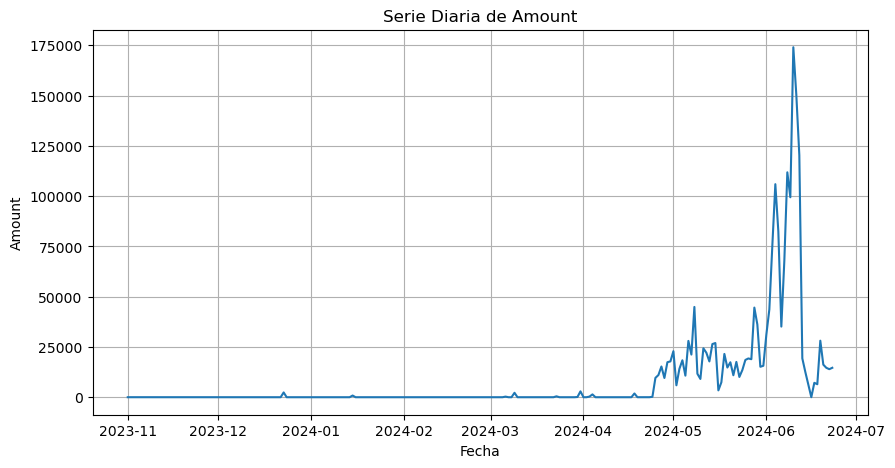

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(datos.index, datos['amount'], marker='', linestyle='-')
plt.title('Serie Diaria de Amount')
plt.xlabel('Fecha')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

In [20]:
#datos.columns.to_list()

In [21]:
datos = datos[['amount', 
                'var_rate_lag_2','var_rate_lag_3','var_rate_lag_4', 'var_rate_lag_5',
                'var_rate_lag_6','var_rate_lag_7',
                'var_rate_lag_8','var_rate_lag_9',
                'var_rate_lag_10','var_rate_lag_11','var_rate_lag_12','var_rate_lag_13', 
                'var_rate_lag_14','var_rate_lag_15','var_rate_lag_16','var_rate_lag_17',
               'var_rate_lag_18','var_rate_lag_19','var_rate_lag_20','var_rate_lag_21',
               'var_rate_lag_22','var_rate_lag_23','var_rate_lag_24','var_rate_lag_25',
                'var_rate_lag_26','var_rate_lag_27','var_rate_lag_28','var_rate_lag_29', 
               'ratio_coupon_tx_lag_2', 
                'ratio_coupon_tx_lag_3', 'ratio_coupon_tx_lag_4', 'ratio_coupon_tx_lag_5', 
                'ratio_coupon_tx_lag_6', 'ratio_coupon_tx_lag_7', 
                'ratio_coupon_tx_lag_8', 
                'ratio_coupon_tx_lag_9', 'ratio_coupon_tx_lag_10', 'ratio_coupon_tx_lag_11', 
                'ratio_coupon_tx_lag_12', 'ratio_coupon_tx_lag_13', 'ratio_coupon_tx_lag_14',
                'ratio_coupon_tx_lag_15','ratio_coupon_tx_lag_16','ratio_coupon_tx_lag_17', 
                'ratio_coupon_tx_lag_18','ratio_coupon_tx_lag_19','ratio_coupon_tx_lag_20',
                'ratio_coupon_tx_lag_21','ratio_coupon_tx_lag_22','ratio_coupon_tx_lag_23',
                'ratio_coupon_tx_lag_24','ratio_coupon_tx_lag_25','ratio_coupon_tx_lag_26',
                'ratio_coupon_tx_lag_27','ratio_coupon_tx_lag_28','ratio_coupon_tx_lag_29',
               'tx_lag_2', 'tx_lag_3','tx_lag_4', 'tx_lag_5','tx_lag_6', 'tx_lag_7', 
                'tx_lag_8', 'tx_lag_9', 'tx_lag_10', 'tx_lag_11','tx_lag_12', 'tx_lag_13',
               'tx_lag_14', 'tx_lag_15', 'tx_lag_16','tx_lag_17', 'tx_lag_18','tx_lag_19',
                'tx_lag_20', 'tx_lag_21',
                 'var_tx_cancelled_lag_2', 'var_tx_cancelled_lag_3', 
                'var_tx_cancelled_lag_4', 'var_tx_cancelled_lag_5', 'var_tx_cancelled_lag_6', 
               'var_tx_cancelled_lag_7', 
               'var_tx_cancelled_lag_8', 'var_tx_cancelled_lag_9', 
                'var_tx_cancelled_lag_10', 'var_tx_cancelled_lag_11', 'var_tx_cancelled_lag_12', 
                'var_tx_cancelled_lag_13', 'var_tx_cancelled_lag_14','var_tx_cancelled_lag_15', 
                'var_tx_cancelled_lag_16', 'var_tx_cancelled_lag_17', 'var_tx_cancelled_lag_18',
                'var_tx_cancelled_lag_19', 'var_tx_cancelled_lag_20','var_tx_cancelled_lag_21', 
                'var_tx_cancelled_lag_22','var_tx_cancelled_lag_23', 'var_tx_cancelled_lag_24',
                'var_tx_cancelled_lag_25', 'var_tx_cancelled_lag_26','var_tx_cancelled_lag_27', 
                'var_tx_cancelled_lag_28', 'var_tx_cancelled_lag_29',
                'margin_lag_2', 'margin_lag_3', 'margin_lag_4', 'margin_lag_5',
                'margin_lag_6', 'margin_lag_7', 
                'margin_lag_8', 'margin_lag_9', 'margin_lag_10', 
               'is_holiday',
               'is_fourth_of_july',
               'var_30ds',
               'christmas_day',
               'new_year_day',
               'post_holiday',
               'day_of_the_dead'
              ]]

In [22]:
# Workaround para payers nuevos
# split_index = int(len(datos) * 0.5)

### TRAINING, VALIDATION AND TESTING PERIODS

In [23]:
# Train-validation-test
# ======================================================================================
fin_train = '2024-05-31'
fin_val = '2024-05-31'
print(
    f"Fechas entrenamiento : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas validacion    : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_val].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_val])})"
)
print(
    f"Fechas test          : {datos.loc[fin_val:].index.min()} --- {datos.index.max()}  "
    f"(n={len(datos.loc[fin_val:])})"
)


Fechas entrenamiento : 2023-11-01 00:00:00 --- 2024-05-31 00:00:00  (n=213)
Fechas validacion    : 2024-05-31 00:00:00 --- 2024-05-31 00:00:00  (n=1)
Fechas test          : 2024-05-31 00:00:00 --- 2024-06-23 00:00:00  (n=24)


### DEFINITION OF EXOGENOUS VARIABLES

In [24]:
exogenas=[
       'var_rate_lag_2','var_rate_lag_3','var_rate_lag_4', 'var_rate_lag_5',
       'var_rate_lag_6','var_rate_lag_7',
       'var_rate_lag_8','var_rate_lag_9',
               'var_rate_lag_10','var_rate_lag_11','var_rate_lag_12','var_rate_lag_13', 
                'var_rate_lag_14','var_rate_lag_15','var_rate_lag_16','var_rate_lag_17',
                'var_rate_lag_18','var_rate_lag_19','var_rate_lag_20','var_rate_lag_21',
                'var_rate_lag_22','var_rate_lag_23','var_rate_lag_24','var_rate_lag_25',
                'var_rate_lag_26','var_rate_lag_27','var_rate_lag_28','var_rate_lag_29', 
                'ratio_coupon_tx_lag_2', 
                'ratio_coupon_tx_lag_3', 'ratio_coupon_tx_lag_4', 'ratio_coupon_tx_lag_5', 
                 'ratio_coupon_tx_lag_6', 'ratio_coupon_tx_lag_7', 
                'ratio_coupon_tx_lag_8', 
               'ratio_coupon_tx_lag_9', 'ratio_coupon_tx_lag_10', 'ratio_coupon_tx_lag_11', 
                'ratio_coupon_tx_lag_12', 'ratio_coupon_tx_lag_13', 'ratio_coupon_tx_lag_14',
                'ratio_coupon_tx_lag_15','ratio_coupon_tx_lag_16','ratio_coupon_tx_lag_17', 
                'ratio_coupon_tx_lag_18','ratio_coupon_tx_lag_19','ratio_coupon_tx_lag_20',
                'ratio_coupon_tx_lag_21','ratio_coupon_tx_lag_22','ratio_coupon_tx_lag_23',
                'ratio_coupon_tx_lag_24','ratio_coupon_tx_lag_25','ratio_coupon_tx_lag_26',
                'ratio_coupon_tx_lag_27','ratio_coupon_tx_lag_28','ratio_coupon_tx_lag_29',
                'tx_lag_2', 'tx_lag_3','tx_lag_4', 'tx_lag_5','tx_lag_6', 'tx_lag_7', 
                'tx_lag_8', 'tx_lag_9', 'tx_lag_10', 'tx_lag_11','tx_lag_12', 'tx_lag_13',
                'tx_lag_14', 'tx_lag_15', 'tx_lag_16','tx_lag_17', 'tx_lag_18','tx_lag_19',
                'tx_lag_20', 'tx_lag_21',
                'var_tx_cancelled_lag_2', 'var_tx_cancelled_lag_3', 
                'var_tx_cancelled_lag_4', 'var_tx_cancelled_lag_5', 'var_tx_cancelled_lag_6', 
                'var_tx_cancelled_lag_7', 
                 'var_tx_cancelled_lag_8', 'var_tx_cancelled_lag_9', 
                'var_tx_cancelled_lag_10', 'var_tx_cancelled_lag_11', 'var_tx_cancelled_lag_12', 
                'var_tx_cancelled_lag_13', 'var_tx_cancelled_lag_14','var_tx_cancelled_lag_15', 
                'var_tx_cancelled_lag_16', 'var_tx_cancelled_lag_17', 'var_tx_cancelled_lag_18',
                'var_tx_cancelled_lag_19', 'var_tx_cancelled_lag_20','var_tx_cancelled_lag_21', 
                'var_tx_cancelled_lag_22','var_tx_cancelled_lag_23', 'var_tx_cancelled_lag_24',
                'var_tx_cancelled_lag_25', 'var_tx_cancelled_lag_26','var_tx_cancelled_lag_27', 
                'var_tx_cancelled_lag_28', 'var_tx_cancelled_lag_29',
                'margin_lag_2', 'margin_lag_3', 'margin_lag_4', 'margin_lag_5',
               'margin_lag_6', 'margin_lag_7', 
               'margin_lag_8', 'margin_lag_9',  'margin_lag_10', 
                'is_holiday',
               'is_fourth_of_july',
               'var_30ds',
               'christmas_day',
               'new_year_day',
               'post_holiday',
               'day_of_the_dead'
              ]

In [25]:
datos[exogenas] = datos[exogenas].fillna(0)

### SELECTION OF SIGNIFICANT EXOGENOUS VARIABLES

In [26]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(2, 1, 1), seasonal_order=(2, 1, 1, 7))
modelo.fit(y=datos['amount'].loc[:fin_train], exog=datos[exogenas].loc[:fin_train] )
modelo.summary()
#warnings.filterwarnings("default")

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            amount   No. Observations:                  213
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -1446.476
Date:                           Thu, 27 Jun 2024   AIC                           3146.953
Time:                                   22:06:30   BIC                           3568.975
Sample:                               11-01-2023   HQIC                          3317.650
                                    - 05-31-2024                                         
Covariance Type:                             opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
var_rate_lag_2           1019.8709   2319.499      0.440      0.660   -3526.264    5566.006
var_rate_lag_3           -964.5213   1582.081     -0.610      0.542   -4065.344    2136.301
var_rate_lag_4            156.6184   2276.410      0.069      0.945   -4305.063    4618.300
var_rate_lag_5           -481.0618   1858.386     -0.259      0.796   -4123.432    3161.309
var_rate_lag_6           -490.6762   1987.158     -0.247      0.805   -4385.434    3404.081
var_rate_lag_7          -2953.9602   2257.034     -1.309      0.191   -7377.665    1469.745
var_rate_lag_8          -3293.9223   2175.091     -1.514      0.130   -7557.023     969.178
var_rate_lag_9            488.4246   4170.195      0.117      0.907   -7685.007    8661.856
var_rate_lag_10         -3043.7903   3343.408     -0.910      0.363   -9596.750    3509.169
var_rate_lag_11          -422.2014   3938.667     -0.107      0.915   -8141.846    7297.443
var_rate_lag_12         -3224.0238   4342.816     -0.742      0.458   -1.17e+04    5287.740
var_rate_lag_13          -280.2713   3986.869     -0.070      0.944   -8094.391    7533.848
var_rate_lag_14         -5314.3365   7513.014     -0.707      0.479      -2e+04    9410.900
var_rate_lag_15         -2560.6358   7791.005     -0.329      0.742   -1.78e+04    1.27e+04
var_rate_lag_16            24.0013   9377.475      0.003      0.998   -1.84e+04    1.84e+04
var_rate_lag_17          -785.3552   7701.406     -0.102      0.919   -1.59e+04    1.43e+04
var_rate_lag_18          1855.4443   1.09e+04      0.170      0.865   -1.96e+04    2.33e+04
var_rate_lag_19          2793.5864   9303.799      0.300      0.764   -1.54e+04     2.1e+04
var_rate_lag_20          2290.5904   9507.861      0.241      0.810   -1.63e+04    2.09e+04
var_rate_lag_21          -944.8262    1.8e+04     -0.053      0.958   -3.62e+04    3.43e+04
var_rate_lag_22         -1141.9875   1.37e+04     -0.084      0.933   -2.79e+04    2.56e+04
var_rate_lag_23           4.52e+04   1.43e+04      3.155      0.002    1.71e+04    7.33e+04
var_rate_lag_24         -8708.1557   1.52e+04     -0.574      0.566   -3.85e+04     2.1e+04
var_rate_lag_25          3.395e+04   1.32e+04      2.572      0.010    8075.739    5.98e+04
var_rate_lag_26          5305.4849   1.32e+04      0.402      0.688   -2.06e+04    3.12e+04
var_rate_lag_27          4.087e+04   1.41e+04      2.904      0.004    1.33e+04    6.84e+04
var_rate_lag_28           2.03e+04   1.02e+04      1.999      0.046     398.938    4.02e+04
var_rate_lag_29          2.617e+04   1.75e+04      1.495      0.135   -8139.916    6.05e+04
ratio_coupon_tx_lag_2     -12.2516   2855.738     -0.004      0.997   -5609.396    5584.893
ratio_coupon_tx_lag_3   -1242.1461   2598.521     -0.478      0.633   -6335.154    3850.861
ratio_coupon_tx_lag_4    1908.7884   3172.665      0.602      0.547   -4309.520    8127.097
ratio_coupon_t

In [27]:

#with open(f'sarimax_summary_{payer}_7d_12_03.txt', 'w') as f:
    #f.write(modelo.summary().as_text())_

In [28]:
# Get summary table as string
tabla_resumen = modelo.summary().tables[1].as_html()
# Convert HTML string to a pandas DataFrame
df_resumen = pd.read_html(tabla_resumen, header=0, index_col=0)[0]
#Filter the DataFrame to keep only the rows that contain p values.
df_valores_p = df_resumen[df_resumen.index.str.contains('P>|z|')]
#Define the significance threshold
umbral_significancia = 0.05
# Filter out the rows where the p-value is less than the significance threshold.
variables_significativas = df_valores_p[df_valores_p['P>|z|'] < umbral_significancia]
indices_variables_significativas = variables_significativas.index.tolist()
# Convert indexes to a list of characters
exogenas_total = list(map(str, indices_variables_significativas))
#Filtered exogenous list
exogenas = [var for var in exogenas_total if not var.startswith(('ar.', 'ma.', 'sigma'))]
# Show filtered exogenous list
print(exogenas)

['var_rate_lag_23', 'var_rate_lag_25', 'var_rate_lag_27', 'var_rate_lag_28', 'ratio_coupon_tx_lag_6', 'ratio_coupon_tx_lag_12', 'ratio_coupon_tx_lag_17', 'ratio_coupon_tx_lag_25', 'ratio_coupon_tx_lag_29', 'tx_lag_6', 'tx_lag_8', 'tx_lag_19', 'margin_lag_5', 'margin_lag_8', 'margin_lag_10']


/tmp/ipykernel_705/159567767.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_resumen = pd.read_html(tabla_resumen, header=0, index_col=0)[0]


In [29]:
# Supongamos que `modelo` es tu modelo previamente ajustado
# Obtener la tabla resumen como cadena de HTML
tabla_resumen = modelo.summary().tables[1].as_html()


In [30]:
#We open the file in write mode, with the 'append' option to add content to the end of the file
#with open(f'sarimax_summary_{payer}_7d_8lags.txt', 'a') as f:
with open(f'sarimax_summary_{payer}_2d.txt', 'a') as f:
    # Escribir el contenido de la variable 'exogenas' en el archivo
    f.write('\n\nContenido de la variable "exogenas":\n')
    f.write(str(exogenas))

### SEARCH THE BEST MODEL 

In [31]:
# Auto arima: Selection of the best model according to Akaike's criteria
# ==============================================================================
resultados_autoarima = auto_arima(
            y                 = datos['amount'].loc[:fin_val],
            exog              = datos[exogenas].loc[:fin_val],
            start_p           = 0, #Start value of the number of autoregressions
            start_q           = 0, #Moving average component order start value
            max_p             = 7, #Maximum order of the autoregressive component
            max_q             = 7, #Maximum order of the moving average component
            seasonal          = True, # It is indicated that the variable has seasonal behavior
            m                 = 7, # Weekly periodicity of seasonality
            max_d             = 2, # Maximum order of integration of the original series
            max_D             = 2, # Maximum order of differentiation of the seasonal series
            trace             = True, #Indicates that all steps in the process of searching for the best model are displayed.
            error_action      = 'ignore',
            suppress_warnings = True, 
            stepwise          = True #Iterate from a simple model to a more complex model by adding autoregressive orders, moving averages and integration.
        )
opt_order_2 = resultados_autoarima.order
opt_seasonal_order_2 = resultados_autoarima.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=4181.779, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4213.996, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4156.610, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4134.210, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4212.045, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=4149.585, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=4117.762, Time=0.52 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=4122.463, Time=0.25 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=4120.426, Time=0.94 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=4130.550, Time=0.27 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=4131.182, Time=0.15 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=4123.297, Time=0.34 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=4123.040, Time=1.06 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,2)(1,0,1)[7] intercept   : 

### MODEL BACKTESTING 

In [32]:
forecaster_autoarima = ForecasterSarimax(
                 regressor=Sarimax(order=opt_order_2, seasonal_order=opt_seasonal_order_2)
             )
metrica_autoarima, predicciones_autoarima = backtesting_sarimax(
                                forecaster            = forecaster_autoarima,##Model fitted with parameters of the best model
                                y                     = datos['amount'],##The target variable is indicated
                                exog                  = datos[exogenas],##Selected exogenous variables
                                initial_train_size    = len(datos.loc[:fin_val]),##Test start period
                                steps                 = 2, ##Number of days to predict
                                metric                = 'mean_absolute_percentage_error',##evaluation metrics
                                refit                 = False,##Indicates not to update the model as it incorporates information
                                n_jobs                = 'auto',
                                suppress_warnings_fit = True,
                                verbose               = False,#Indicates not to show the entire iterative process
                                show_progress         = True#Indicates the degree of progress of the process.
                            )
# Prediction
nueva_fecha = datetime.strptime(fin_val, '%Y-%m-%d') + timedelta(days=1)
predicciones_autoarima = predicciones_autoarima['pred']

# Combining the two DataFrames into one
resultados_predichos_autoarima= pd.DataFrame({'date': predicciones_autoarima.index, 'valor_real': datos['amount'].loc[nueva_fecha:], 'valor_predicho': predicciones_autoarima})
# MAPE calculation
resultados_predichos_autoarima['mape'] = abs((resultados_predichos_autoarima['valor_real'] - resultados_predichos_autoarima['valor_predicho']) / resultados_predichos_autoarima['valor_real']) * 100
resultados_predichos_autoarima['error_abs'] = abs((resultados_predichos_autoarima['valor_real'] - resultados_predichos_autoarima['valor_predicho']))
# Calculate the average of the 'mape' column
promedio_mape_autoarima = resultados_predichos_autoarima['mape'].mean()
promedio_error_abs_autoarima = resultados_predichos_autoarima['error_abs'].mean()
# Print the average
print("Promedio de la columna 'mape' - 2 dias:", promedio_mape_autoarima)
print("Promedio de la columna 'error_abs' - 2 dias:", promedio_error_abs_autoarima)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/12 [00:00<?, ?it/s]

Promedio de la columna 'mape' - 2 dias: inf
Promedio de la columna 'error_abs' - 2 dias: 56888.20971247729


### FIT

In [33]:
datos=datos.loc[datos.index<'2024-05-31']

In [34]:
datos.index.max()

Timestamp('2024-05-30 00:00:00')

In [35]:
forecaster_autoarima.fit(y=datos['amount'],exog=datos[exogenas] ,suppress_warnings=True)

In [36]:
forecaster_autoarima

ForecasterSarimax 
Regressor: Sarimax(0,1,1)(1,0,1)[7] 
Regressor parameters: {'concentrate_scale': False, 'dates': None, 'disp': False, 'enforce_invertibility': True, 'enforce_stationarity': True, 'freq': None, 'hamilton_representation': False, 'maxiter': 50, 'measurement_error': False, 'method': 'lbfgs', 'missing': 'none', 'mle_regression': True, 'order': (0, 1, 1), 'seasonal_order': (1, 0, 1, 7), 'simple_differencing': False, 'sm_fit_kwargs': {}, 'sm_init_kwargs': {}, 'sm_predict_kwargs': {}, 'start_params': None, 'time_varying_regression': False, 'trend': None, 'trend_offset': 1, 'use_exact_diffuse': False, 'validate_specification': True} 
fit_kwargs: {} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['var_rate_lag_23', 'var_rate_lag_25', 'var_rate_lag_27', 'var_rate_lag_28', 'ratio_coupon_tx_lag_6', 'ratio_coupon_tx_lag_12', 'ratio_coupon_t

In [37]:
##Influential variables##
feat_imp=forecaster_autoarima.get_feature_importances()
feat_imp

,feature,importance
18,sigma2,1.312345e+07
0,var_rate_lag_23,2.359065e+04
3,var_rate_lag_28,1.112439e+04
7,ratio_coupon_tx_lag_25,1.022691e+04
5,ratio_coupon_tx_lag_12,7.492854e+03
6,ratio_coupon_tx_lag_17,3.029221e+03
2,var_rate_lag_27,2.252268e+03
1,var_rate_lag_25,1.354920e+03
9,tx_lag_6,8.407701e+01
13,margin_lag_8,4.591495e+01


In [38]:
pd.set_option('display.max_rows', None)
feat_imp.sort_values(by='importance', ascending=False)

,feature,importance
18,sigma2,1.312345e+07
0,var_rate_lag_23,2.359065e+04
3,var_rate_lag_28,1.112439e+04
7,ratio_coupon_tx_lag_25,1.022691e+04
5,ratio_coupon_tx_lag_12,7.492854e+03
6,ratio_coupon_tx_lag_17,3.029221e+03
2,var_rate_lag_27,2.252268e+03
1,var_rate_lag_25,1.354920e+03
9,tx_lag_6,8.407701e+01
13,margin_lag_8,4.591495e+01


In [39]:
with open(f'sarimax_summary_{payer}_2d.txt', 'a') as f:
    # Escribir el contenido de la variable 'exogenas' en el archivo
    f.write('\n\nContenido de la variable "exogenas":\n')
    f.write(str(forecaster_autoarima))

In [40]:
modelo_final = forecaster_autoarima
resultados_predichos = resultados_predichos_autoarima
mape_final = promedio_mape_autoarima

In [42]:
# Create a folder called 'results' if it does not exist
folder_name = '/new_payers/'
carpeta_resultados = path2+folder_name+payer+'/'
print(carpeta_resultados)

try:
    client.put_object(Bucket=bucket_name, Key=(carpeta_resultados+'/'))
    print(f"Carpeta '{carpeta_resultados}' creada en el bucket '{bucket_name}'.")
except Exception as e:
    print(f"Error al crear la carpeta: {e}")
    

ABTv3_update/new_payers/PUBALI BANK_BANGLADESH/
Carpeta 'ABTv3_update/new_payers/PUBALI BANK_BANGLADESH/' creada en el bucket 'viamericas-datalake-dev-us-east-1-283731589572-analytics'.


### SAVES THE RESULTS IN AN EXCEL FILE AND THE MODEL IN A PICKLE FILE

In [43]:


#WE SAVE RESULTS IN EXCEL

nombre_archivo_excel = os.path.join(carpeta_resultados, 'predicciones_test_2d_'+payer+'_2d'+'v2'+'.xlsx')
# Guarda el DataFrame en un objeto BytesIO como archivo Excel
#excel_buffer = BytesIO()
#resultados_predichos.to_excel(excel_buffer, index=False)
# Save the DataFrame to an XLSX file in S3 using AWS Data Wrangler
wr.s3.to_excel(resultados_predichos, f"s3://{bucket_name}/{nombre_archivo_excel}", index=False)


nombre_archivo_pickle = os.path.join(carpeta_resultados, 'MODEL_2d_'+payer+'_2d'+'v2'+'.pkl')
# Save the model in a temporary pickle file
modelo_temp_file = 'MODEL_2d_'+payer+'.pkl'
joblib.dump(modelo_final, modelo_temp_file)

# Upload the pkl file to S3
try:
    wr.s3.upload(modelo_temp_file, f"s3://{bucket_name}/{nombre_archivo_pickle}")
    print(f"Modelo guardado como pkl en S3: {nombre_archivo_pickle}")
    os.remove(modelo_temp_file) # Elimina el temporal
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")


Modelo guardado como pkl en S3: ABTv3_update/new_payers/PUBALI BANK_BANGLADESH/MODEL_2d_PUBALI BANK_BANGLADESH_2dv2.pkl


In [44]:
#TXT
file_name = f'sarimax_summary_{payer}_2d.txt'
ruta_txt = os.path.join(carpeta_resultados, file_name)
# Cargar el archivo en S3
s3 = boto3.resource("s3")
s3.Bucket(bucket_name).upload_file(file_name, ruta_txt)
os.remove(file_name) # Elimina el temporal

In [45]:
# Celda de finalización
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de ejecución total: {elapsed_time} segundos")

Tiempo de ejecución total: 105.67391204833984 segundos
